In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression, Ridge
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.multioutput import MultiOutputRegressor
import joblib
import os


In [2]:
df = pd.read_excel('../data/meta_ads_cleaned.xlsx', engine='openpyxl')

app_installs_df = df[df['Result indicator'] == 'actions:mobile_app_install'].copy()
app_installs_df.reset_index(drop=True, inplace=True)

app_installs_df.head()

,Campaign name,Campaign Delivery,Platforme,Device,Placement,Objective,Result indicator,Ad set budget,Ad set budget type,Amount spent,...,Cost per app install (USD),Adds to cart,Adds to cart conversion value,Cost per add to cart (USD),Checkouts Initiated,Checkouts initiated conversion value,Cost per checkout initiated (USD),Landing page views,Cost per landing page view (USD),Cost per purchase (USD)
0,SO/2024/0318 - Campagne Ramadan 2 - BC : - In...,not_delivering,Audience Network,In-app,Feed,App Installs,actions:mobile_app_install,2.63,Using ad set budget,2.63,...,2.630000,0,0.0,0.00,0,0.0,0.00000,0,0.00,0.0
1,SO/2024/0318 - Campagne Ramadan 2 - BC : - In...,not_delivering,Audience Network,In-app,Facebook Stories,App Installs,actions:mobile_app_install,25.83,Using ad set budget,25.83,...,0.993462,0,0.0,0.00,3,0.0,8.61000,0,0.00,0.0
2,SO/2024/0318 - test 1$ - Campagne Ramadan 2 - ...,not_delivering,Audience Network,In-app,"Native, banner & interstitial",App Installs,actions:mobile_app_install,6.47,Using ad set budget,6.47,...,0.215667,1,0.0,6.47,8,0.0,0.80875,1,6.47,0.0
3,SO/2024/0318 - Campagne Ramadan 2 - Campagne ...,not_delivering,Audience Network,In-app,Feed,App Installs,actions:mobile_app_install,8.34,Using ad set budget,8.34,...,2.085000,0,0.0,0.00,0,0.0,0.00000,0,0.00,0.0
4,SO/2024/0318 - Campagne Ramadan 2 - BC : - In...,not_delivering,Facebook,In-app,Facebook Stories,App Installs,actions:mobile_app_install,24.72,Using ad set budget,24.72,...,1.177143,0,0.0,0.00,6,0.0,4.12000,1,24.72,0.0


In [3]:
categorical_cols = ['Platforme', 'Placement', 'Device', 'Ad set budget type']

app_installs_df_encoded = pd.get_dummies(app_installs_df, columns=categorical_cols, drop_first=True)


In [4]:
app_installs_df_encoded['Starts'] = pd.to_datetime(app_installs_df_encoded['Starts'])

app_installs_df_encoded['day'] = app_installs_df_encoded['Starts'].dt.day
app_installs_df_encoded['month'] = app_installs_df_encoded['Starts'].dt.month
app_installs_df_encoded['weekday'] = app_installs_df_encoded['Starts'].dt.weekday


In [5]:
app_installs_df_encoded['log_spend'] = np.log1p(app_installs_df_encoded['Amount spent'])
app_installs_df_encoded['log_reach'] = np.log1p(app_installs_df_encoded['Reach'])
app_installs_df_encoded['log_impressions'] = np.log1p(app_installs_df_encoded['Impressions'])
app_installs_df_encoded['log_clicks'] = np.log1p(app_installs_df_encoded['Clicks (all)'])
app_installs_df_encoded['log_lp_views'] = np.log1p(app_installs_df_encoded['Landing page views'])
app_installs_df_encoded['log_installs'] = np.log1p(app_installs_df_encoded['App installs'])
app_installs_df_encoded['log_cpi'] = np.log1p(app_installs_df_encoded['Cost per app install (USD)'])
app_installs_df_encoded['log_ctr'] = np.log1p(app_installs_df_encoded['CTR (all)'])
app_installs_df_encoded['log_cpc'] = np.log1p(app_installs_df_encoded['CPC (all) (USD)'])


In [6]:
app_model_df = app_installs_df_encoded.copy()

# Drop irrelevant text columns
app_model_df = app_model_df.drop(columns=[
    'Campaign name', 'Campaign Delivery', 'Objective', 'Result indicator', 'Attribution setting'
], errors='ignore')

# Drop raw numeric columns already transformed
app_model_df.drop([
    'Amount spent', 'Reach', 'Impressions', 'Clicks (all)',
    'Landing page views', 'App installs', 'Cost per app install (USD)',
    'CTR (all)', 'CPC (all) (USD)', 'Starts', 'Date created', 'Ends'
], axis=1, inplace=True)


In [7]:
# Target
y_app_installs = app_model_df['log_installs']

# Features
X_app_installs = app_model_df.drop([
    'log_installs', 'log_ctr', 'log_cpc'  # drop weak predictors
], axis=1)

# Keep only numeric features
X_app_installs = X_app_installs.select_dtypes(include=[np.number])


In [8]:
X_train_app, X_test_app, y_train_app, y_test_app = train_test_split(
    X_app_installs, y_app_installs, test_size=0.2, random_state=42
)


In [9]:
lr_app = LinearRegression()
lr_app.fit(X_train_app, y_train_app)

lr_preds_app = lr_app.predict(X_test_app)


In [10]:
ridge_app = Ridge(alpha=1.0)
ridge_app.fit(X_train_app, y_train_app)

ridge_preds_app = ridge_app.predict(X_test_app)


In [11]:
rf_app = RandomForestRegressor(n_estimators=100, random_state=42)
rf_app.fit(X_train_app, y_train_app)

rf_preds_app = rf_app.predict(X_test_app)


In [12]:
xgb_app = XGBRegressor(n_estimators=100, learning_rate=0.1, random_state=42)
xgb_app.fit(X_train_app, y_train_app)

xgb_preds_app = xgb_app.predict(X_test_app)


In [13]:
def evaluate_model(y_true, y_pred, model_name):
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    r2 = r2_score(y_true, y_pred)

    print(f" {model_name}")
    print(f"RMSE: {rmse:.4f}")
    print(f"R² Score: {r2:.4f}")
    print("-"*50)

# Evaluate
evaluate_model(y_test_app, lr_preds_app, "Linear Regression")
evaluate_model(y_test_app, ridge_preds_app, "Ridge Regression")
evaluate_model(y_test_app, rf_preds_app, "Random Forest")
evaluate_model(y_test_app, xgb_preds_app, "XGBoost")


 Linear Regression
RMSE: 8.4604
R² Score: -12.4407
--------------------------------------------------
 Ridge Regression
RMSE: 8.4532
R² Score: -12.4176
--------------------------------------------------
 Random Forest
RMSE: 1.3175
R² Score: 0.6741
--------------------------------------------------
 XGBoost
RMSE: 0.7490
R² Score: 0.8946
--------------------------------------------------


##  App Install Campaigns – Model Comparison

| Model              | RMSE   | R² Score |
|--------------------|--------|----------|
| Linear Regression  | 8.4604 | -12.4407 |
| Ridge Regression   | 8.4532 | -12.4176 |
| Random Forest      | 1.3175 | 0.6741   |
| XGBoost            | 0.7490 | 0.8946   |

 **Selected Model**: XGBoost

XGBoost delivered the best RMSE and R² performance for App Install campaign prediction.


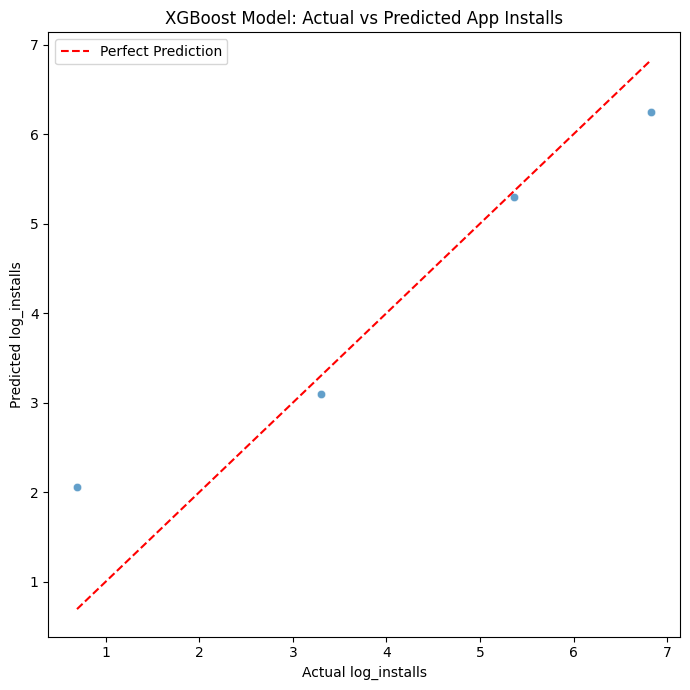

In [14]:
import matplotlib.pyplot as plt
import seaborn as sns

# Predict again to make sure
xgb_preds_app = xgb_app.predict(X_test_app)

# Set up the plot
plt.figure(figsize=(7, 7))

sns.scatterplot(x=y_test_app, y=xgb_preds_app, alpha=0.7)
plt.plot([y_test_app.min(), y_test_app.max()],
         [y_test_app.min(), y_test_app.max()],
         '--r', label='Perfect Prediction')

plt.xlabel("Actual log_installs")
plt.ylabel("Predicted log_installs")
plt.title("XGBoost Model: Actual vs Predicted App Installs")
plt.legend()

plt.tight_layout()
plt.show()


In [15]:
# Save the XGBoost model
joblib.dump(xgb_app, "../models/xgb_app_installs_model.joblib")

feature_columns = X_train_app.columns.tolist()
joblib.dump(X_train_app.columns.tolist(), "../models/app_installs_model_features.pkl")

['../models/app_installs_model_features.pkl']

## Model Persistence – App Installs Campaigns

The final XGBoost model (`xgb_app`) for predicting app installs was saved for future use.

-  File saved: `../models/xgb_app_installs_model.joblib`
-  Ready for deployment or integration into real-time dashboards.
